# Implementation of Machine Learning Algorithms on Titanic Survivor Dataset (Classification Task)
This notebook implements some Machine Learning classification algorithms on the Titanic Survivor Dataset. The dataset has been provided by Kaggle. https://www.kaggle.com/c/titanic/data

## 1. Logistic Regression
We begin by first implementing logistic regression.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit, learning_curve, validation_curve
from sklearn.preprocessing import MinMaxScaler
from Utils import *
from LogisticRegression import LogisticRegression
from ImputationTransform import ImputationTransform
%matplotlib inline

In [3]:
train, test = load_dataset()
print("initial train data size (with label)", train.shape)

train_X, train_y = preprocess(train, impute_data=True, normalize_data=True)
print("updated train data size (without label)", train_X.shape)

initial train data size (with label) (891, 12)
updated train data size (without label) (891, 10)


### Gradient Descent
Below, we see the effect of varying learning rate on Gradient Descent Algorithm. As learning rate increases, the convergence is reached faster - i.e. at earlier iteration. Looking at this graph, we can verify that our implementation of Gradient Descent is working as expected.

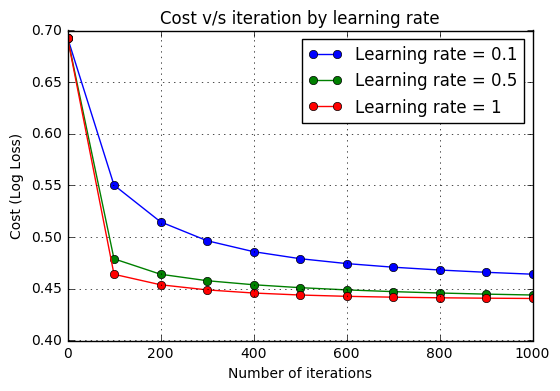

In [4]:
learning_rate = [0.1, 0.5, 1]
max_iter = 1000
iteration_threshold = 100

cost_by_lr, iterations, plotlabels = get_multiple_estimates(train_X, train_y, learning_rate, 
                                                            max_iter, iteration_threshold, reg_strength=0, 
                                                            regularization="Ridge")

plot_curve(Ylist=cost_by_lr, Xlist=iterations, title="Cost v/s iteration by learning rate", 
           xlabel="Number of iterations", ylabel="Cost (Log Loss)", plotlabels=plotlabels)

### Analysis
#### Learning Curves
Now, we move on to analyze if logistic regression with our set of features is a 'good' algorithm for this dataset. Specifically, we will look for evidence of underfitting (high bias) or overfitting (high variance) by plotting the learning curve, i.e. measuring accuracy on training and a held out validation set with varying size of training data.  

In [4]:
train, test = load_dataset()
print("initial train data size (with label)", train.shape)

train_X, train_y = preprocess(train, impute_data=False, normalize_data=False)
print("updated train data size (without label)", train_X.shape)

# use scikit's pipeline functionality to chain pre-processing steps to avoid leakage
estimators = [('impute', ImputationTransform()), ('scale', MinMaxScaler()), 
                                          ('logReg', LogisticRegression(learning_rate=1, cost_threshold=0.00001))]
pipeline = Pipeline(estimators)

initial train data size (with label) (891, 12)
updated train data size (without label) (891, 10)


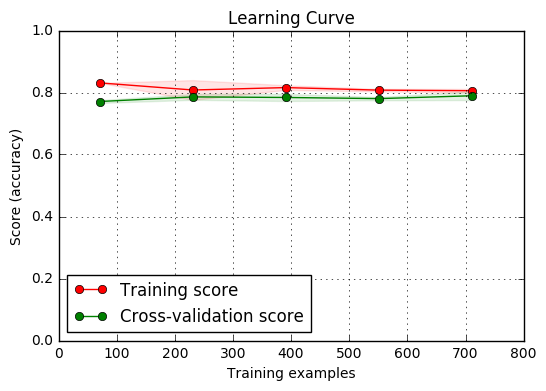

In [5]:
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=3)
plot_learning_curve(estimator=pipeline, title="Learning Curve", X=train_X, y=train_y, ylim=(0, 1), cv=cv, 
                    train_sizes=np.linspace(.1, 1.0, 5), scoring="accuracy")

Looking at the above curve, we can see that increasing dataset size is not improving the accuracy on the validation set. The performance on training and validation set is very close to each other. We suffer from a 'high bias' or underfitting problem. In other words, either the algorithm or the features are too simplistic to achieve good training and validation performance.

#### Validation Curves
The learning curve from above suggests that we have a 'high bias' problem. This should mean that increasing strength of regularization should not help much in achieving higher validation set performance because regularization further increases the bias. Here, we plot the validation curve - i.e. vary hyperparameter strength of regularization and measure the accuracy.

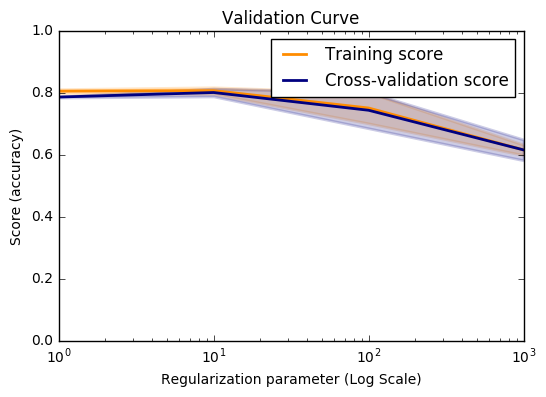

In [6]:
param_range = [1, 10, 100, 1000]
plot_validation_curve(
        estimator=pipeline, title="Validation Curve", X=train_X, y=train_y, 
    param_name="logReg__reg_strength", param_range=param_range, cv=3, scoring="accuracy", 
    ylim=(0, 1))

#### Grid Search
As predicted by the analysis of learning curve, increasing strength of regularization only slightly improves the performance. We will do a fine tuned grid search below to find the best hyperparameter. Looking at the results, we find that for the given set of features, a logistic regression model with regularization parameter value of 35 performs best on the validation set. To improve the model performance, we will either have to use a more complex algorithm or more complex set of features.

In [8]:
param_values = [0, 1, 3, 10, 15, 20, 25, 27, 28, 30, 35, 38, 40]
param_grid = dict(logReg__reg_strength=param_values)
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='accuracy', cv=3, 
                           return_train_score=True)

grid_search.fit(train_X, train_y)

print("Regularization param values: " + str(param_values))
print("Mean train scores: " + str(grid_search.cv_results_['mean_train_score']))
print("Mean test scores: " + str(grid_search.cv_results_['mean_test_score']))

Regularization param values: [0, 1, 3, 10, 15, 20, 25, 27, 28, 30, 35, 38, 40]
Mean train scores: [ 0.80920314  0.80527497  0.80022447  0.80808081  0.80695847  0.81088664
  0.81144781  0.81144781  0.81200898  0.81144781  0.81144781  0.80695847
  0.80078563]
Mean test scores: [ 0.78900112  0.78675645  0.78338945  0.80022447  0.80246914  0.80695847
  0.81144781  0.81144781  0.81144781  0.81144781  0.81144781  0.80808081
  0.80022447]


#### Prediction on test data
Here, we have the code to predict test labels using best performing model found in the previous step (Grid search). We finally write the output to a file.

In [7]:
train, test = load_dataset()
print("initial train data size (with label)", train.shape)

train_X, train_y = preprocess(train, impute_data=False, normalize_data=False)
print("updated train data size (without label)", train_X.shape)

test_X, test_y = preprocess(test, impute_data=False, normalize_data=False, is_train=False)
print("updated test data size (without label)", test_X.shape)

# use scikit's pipeline functionality to chain pre-processing steps to avoid leakage
estimators = [('impute', ImputationTransform()), ('scale', MinMaxScaler()), 
                                          ('logReg', LogisticRegression(learning_rate=1, cost_threshold=0.00001))]
pipeline = Pipeline(estimators)

# set regularization strength
pipeline.set_params(logReg__reg_strength=35).fit(train_X, train_y)

prediction = pipeline.predict(test_X)

test_y = test_y.reshape((test_y.shape[0],))

d = {'PassengerId': test_y, 'Survived': prediction}

pred_df = pd.DataFrame(data=d)

write_to_file(pred_df, 'logreg_test.csv', sep=',')

initial train data size (with label) (891, 12)
updated train data size (without label) (891, 10)
updated test data size (without label) (418, 10)
